# Capstone - Delivery-2
This dataset is part of the [Farming Systems Project](https://www.ars.usda.gov/northeast-area/beltsville-md-barc/beltsville-agricultural-research-center/sustainable-agricultural-systems-laboratory/docs/farming-systems-project/) at USDA, Beltsville MD.  This data is not available online on the USDA
 website but can be found on my [GitHub](https://github.com/mmtokay/DATA606/tree/master/datasets).


The data is split in two files, one that contains crop information and other with weather data.

Crop file:
* Crop - wheat, corn or soybean           
* GrowingSeason - year crop was cultivated 
* SystemName - crop management (traditional: NT and CT; organic: Org2, Org3 and Org6')    
* GrainYield - grain yield measured in kg/ha     
* PlantingDate - date seeds were planted  
* HarvestDate - date crop was harvested


Weather file:
* Year 
* Julian Day 
* Month
* Day
* Date
* avgtTempC - average temperature in C
* maxTempC - maximum temperature in C
* minTempC - minimum temperature in C
* maxHumPct - maximum humidity in %
* minHumPct - minimum humidity in %
* avgRadWm-2 - average radiation in w/m2
* meanWindMs-1 - mean wind in m/s
* PrecipitationMm - precipitation/snow melt in mm

# Exploratory Data Analysis (Preliminary)


In [5]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import warnings
import time

from datetime import datetime, timedelta
from __future__ import print_function

from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, RobustScaler, Normalizer, MinMaxScaler, StandardScaler, Binarizer
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.utils import shuffle
from time import time

warnings.simplefilter(action='ignore', category=FutureWarning)

# Crop Data
Import crop data file.

In [8]:
data = pd.read_csv('FSPGrainYieldsV3Clean.csv')
print(data.head())
print('\nData information.')
print(data.info())

  Crop  GrowingSeason SystemName  GrainYield PlantingDate HarvestDate
0  CRN           1996         NT     10488.0    5/23/1996  10/17/1996
1  CRN           1996         NT      9722.5    5/23/1996  10/17/1996
2  CRN           1996         NT     10008.0    5/23/1996  10/17/1996
3  CRN           1996         NT      8928.8    5/23/1996  10/17/1996
4  CRN           1996         CT     10985.3    5/23/1996  10/17/1996

Data information.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Data columns (total 6 columns):
Crop             1113 non-null object
GrowingSeason    1113 non-null int64
SystemName       1113 non-null object
GrainYield       1113 non-null float64
PlantingDate     1113 non-null object
HarvestDate      1042 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 52.2+ KB
None


Data contains 6 columns and 1113 rows.

Data conversion:
*   Convert GrainYield to numeric.
*   Convert PlantingDate and HarvestDate to datetime.



In [9]:
# Convert from object to float64
data['GrainYield'] = pd.to_numeric(data.GrainYield, errors='coerce')

# Convert PlantingDate and HarvestDate from object to date
data['PlantingDate'] = pd.to_datetime(data.PlantingDate)
data['HarvestDate'] = pd.to_datetime(data.HarvestDate)

Let's check if there is any data missing on the dataset.  

In [10]:
data.isna().sum()

Crop              0
GrowingSeason     0
SystemName        0
GrainYield        0
PlantingDate      0
HarvestDate      71
dtype: int64

I don't have harvest date for 71 measurements.  Harvest date is not critical because often times the crop is not harvest as soon as the crop is mature.  It is important to know how long each crop takes to mature on average.  I will create a new column called weekDuration to calculate the week duration between planting date and harvest date.

In [11]:
# Calculate duration between PlantingDate and HarvestDate
data['weekDuration'] = data['HarvestDate'] - data['PlantingDate']
data['weekDuration'] = data['weekDuration']/np.timedelta64(1,'W')
print('\nCheck unique values for Crop, GrowingSeason and SystemName columns.\n')
print("Crop", data.Crop.unique())
print("\nGrowing Season", data.GrowingSeason.unique())
print("\nCrop Management Type", data.SystemName.unique())


Check unique values for Crop, GrowingSeason and SystemName columns.

Crop ['CRN' 'SOY' 'WHT']

Growing Season [1996 1997 1998 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016]

Crop Management Type ['NT' 'CT' 'Org2' 'Org3' 'Org6' 'ORG2' 'ORG3' 'ORG6']


There are duplicate values for SystemManagement because column values are case sensitive.  I will convert SystemName column to uppercase.

**Note:** There is no data for 1999 because it was a dry year and this experiment doesn't use irrigation, crops never matured.

In [12]:
data['SystemName'] = data['SystemName'].str.upper()
print("\nCrop Management Type", data.SystemName.unique())


Crop Management Type ['NT' 'CT' 'ORG2' 'ORG3' 'ORG6']


I will create a new column called SystemNameType for conventional and organic management.  These values will be generated from SystemName column. 

Conventional = NT and CT

Organic = ORG2, ORG3 and ORG6

In [13]:
# 1 for conventional
# 0 for organic
data['SystemNameType'] = ((data.SystemName == "NT") | (data.SystemName == "CT")).map({True:'1', False:'0'})
# Drop SystemName column
data.drop('SystemName', axis=1, inplace=True)
data.head()

,Crop,GrowingSeason,GrainYield,PlantingDate,HarvestDate,weekDuration,SystemNameType
0,CRN,1996,10488.0,1996-05-23,1996-10-17,21.0,1
1,CRN,1996,9722.5,1996-05-23,1996-10-17,21.0,1
2,CRN,1996,10008.0,1996-05-23,1996-10-17,21.0,1
3,CRN,1996,8928.8,1996-05-23,1996-10-17,21.0,1
4,CRN,1996,10985.3,1996-05-23,1996-10-17,21.0,1


I will separate the data by crop: corn, soybean and wheat and I will display basic statistics for each crop.

# Corn dataset - Statistics

In [14]:
data_corn = data.loc[data['Crop'] == "CRN"]
print(data_corn.describe(include="all"))
print('\nCorn Data Distribution by Year\n')
data_corn_grouped = data_corn.groupby(['GrowingSeason'], as_index=False).agg({'GrainYield': "count"})
print(data_corn_grouped.head())

       Crop  GrowingSeason    GrainYield         PlantingDate  \
count   390     390.000000    390.000000                  390   
unique    1            NaN           NaN                   43   
top     CRN            NaN           NaN  2009-06-29 00:00:00   
freq    390            NaN           NaN                   16   
first   NaN            NaN           NaN  1996-05-23 00:00:00   
last    NaN            NaN           NaN  2016-06-09 00:00:00   
mean    NaN    2006.376923   5746.695385                  NaN   
std     NaN       5.932697   3350.745309                  NaN   
min     NaN    1996.000000     71.900000                  NaN   
25%     NaN    2002.000000   2811.000000                  NaN   
50%     NaN    2007.000000   5791.500000                  NaN   
75%     NaN    2011.000000   8274.950000                  NaN   
max     NaN    2016.000000  13170.200000                  NaN   

                HarvestDate  weekDuration SystemNameType  
count                   370   

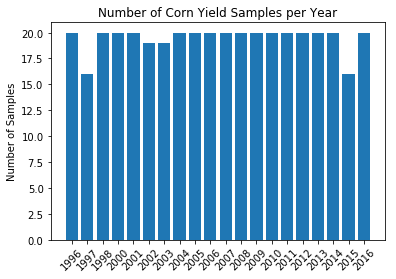

In [31]:
y_pos = np.arange(len(data_corn_grouped['GrowingSeason']))
plt.bar(y_pos, data_corn_grouped['GrainYield'], align='center')
plt.xticks(y_pos, data_corn_grouped['GrowingSeason'], rotation=45)
plt.ylabel('Number of Samples')
plt.title('Number of Corn Yield Samples per Year')
plt.show()

Corn Data Distribution by Crop Management Type

In [25]:
data_corn_sys_grouped = data_corn.groupby(['SystemNameType'], as_index=False).agg({'GrainYield': "count"})
data_corn_sys_grouped.head()

,SystemNameType,GrainYield
0,0,234
1,1,156


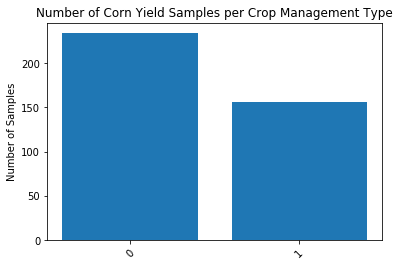

In [32]:
y_pos = np.arange(len(data_corn_sys_grouped['SystemNameType']))
plt.bar(y_pos, data_corn_sys_grouped['GrainYield'], align='center')
plt.xticks(y_pos, data_corn_sys_grouped['SystemNameType'], rotation=45)
plt.ylabel('Number of Samples')
plt.title('Number of Corn Yield Samples per Crop Management Type')
plt.show()

# Soybean dataset - Statistics

In [33]:
data_soy = data.loc[data['Crop'] == "SOY"]
print(data_soy.describe(include="all"))
print('\nSoybean Data Distribution by Year\n')
data_soy_grouped = data_soy.groupby(['GrowingSeason'], as_index=False).agg({'GrainYield': "count"})
print(data_soy_grouped.head())

       Crop  GrowingSeason   GrainYield         PlantingDate  \
count   500     500.000000   500.000000                  500   
unique    1            NaN          NaN                   49   
top     SOY            NaN          NaN  2001-05-30 00:00:00   
freq    500            NaN          NaN                   20   
first   NaN            NaN          NaN  1996-05-23 00:00:00   
last    NaN            NaN          NaN  2016-07-14 00:00:00   
mean    NaN    2006.768000  2647.311400                  NaN   
std     NaN       5.767556  1156.686365                  NaN   
min     NaN    1996.000000   165.200000                  NaN   
25%     NaN    2002.000000  1888.100000                  NaN   
50%     NaN    2007.000000  2578.600000                  NaN   
75%     NaN    2012.000000  3484.250000                  NaN   
max     NaN    2016.000000  5198.700000                  NaN   

                HarvestDate  weekDuration SystemNameType  
count                   465    465.000000   

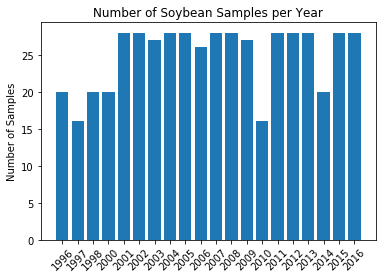

In [34]:
y_pos = np.arange(len(data_soy_grouped['GrowingSeason']))
plt.bar(y_pos, data_soy_grouped['GrainYield'], align='center')
plt.xticks(y_pos, data_soy_grouped['GrowingSeason'], rotation=45)
plt.ylabel('Number of Samples')
plt.title('Number of Soybean Samples per Year')
plt.show()

Soybean Data Distribution by Crop Management Type

In [36]:
data_soy_sys_grouped = data_soy.groupby(['SystemNameType'], as_index=False).agg({'GrainYield': "count"})
data_soy_sys_grouped.head()

,SystemNameType,GrainYield
0,0,227
1,1,273


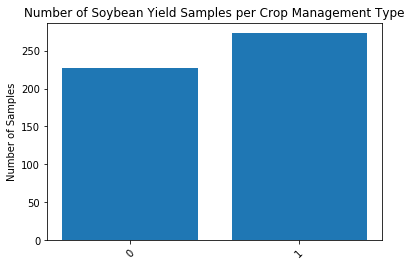

In [37]:
y_pos = np.arange(len(data_soy_sys_grouped['SystemNameType']))
plt.bar(y_pos, data_soy_sys_grouped['GrainYield'], align='center')
plt.xticks(y_pos, data_soy_sys_grouped['SystemNameType'], rotation=45)
plt.ylabel('Number of Samples')
plt.title('Number of Soybean Yield Samples per Crop Management Type')
plt.show()

# Wheat dataset - Statistics

In [38]:
data_wheat = data.loc[data['Crop'] == "WHT"]
print(data_wheat.describe(include="all"))
print('\nWheat Data Distribution by Year\n')
data_wheat_grouped = data_wheat.groupby(['GrowingSeason'], as_index=False).agg({'GrainYield': "count"})
print(data_wheat_grouped.head())

       Crop  GrowingSeason   GrainYield         PlantingDate  \
count   223     223.000000   223.000000                  223   
unique    1            NaN          NaN                   19   
top     WHT            NaN          NaN  2001-10-26 00:00:00   
freq    223            NaN          NaN                   16   
first   NaN            NaN          NaN  1996-11-04 00:00:00   
last    NaN            NaN          NaN  2015-11-17 00:00:00   
mean    NaN    2007.578475  4278.827354                  NaN   
std     NaN       6.094000  1064.753320                  NaN   
min     NaN    1997.000000  1403.500000                  NaN   
25%     NaN    2001.500000  3671.850000                  NaN   
50%     NaN    2009.000000  4427.700000                  NaN   
75%     NaN    2013.000000  5075.900000                  NaN   
max     NaN    2016.000000  6967.000000                  NaN   

                HarvestDate  weekDuration SystemNameType  
count                   207    207.000000   

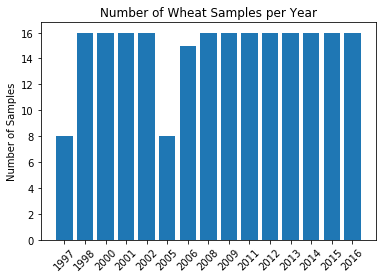

In [39]:
y_pos = np.arange(len(data_wheat_grouped['GrowingSeason']))
plt.bar(y_pos, data_wheat_grouped['GrainYield'], align='center')
plt.xticks(y_pos, data_wheat_grouped['GrowingSeason'], rotation=45)
plt.ylabel('Number of Samples')
plt.title('Number of Wheat Samples per Year')
plt.show()

Wheat Data Distribution by Crop Management Type

In [40]:
data_wheat_sys_grouped = data_wheat.groupby(['SystemNameType'], as_index=False).agg({'GrainYield': "count"})
data_wheat_sys_grouped.head()

,SystemNameType,GrainYield
0,0,108
1,1,115


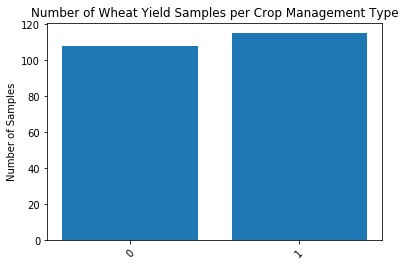

In [41]:
y_pos = np.arange(len(data_wheat_sys_grouped['SystemNameType']))
plt.bar(y_pos, data_wheat_sys_grouped['GrainYield'], align='center')
plt.xticks(y_pos, data_wheat_sys_grouped['SystemNameType'], rotation=45)
plt.ylabel('Number of Samples')
plt.title('Number of Wheat Yield Samples per Crop Management Type')
plt.show()

# Weather Data

Import weather data.

In [44]:
weather_data = pd.read_csv('FSPWeather1996-2019V2.csv')
print(weather_data.head())
print('\nData information.\n')
print(weather_data.info())

   Year  JulianDay  Month   Day      Date  avgtTempC  maxTempC  minTempC  \
0  1996          1      1     1  1/1/1996        3.3       4.2       2.4   
1  1996          2      1     2  1/2/1996        3.2       3.9       1.9   
2  1996          3      1     3  1/3/1996        1.4       5.5      -3.8   
3  1996          4      1     4  1/4/1996       -3.8       0.2      -5.9   
4  1996          5      1     5  1/5/1996       -2.5       1.0      -4.9   

   maxHumPct  minHumPct  avgRadWm-2  meanWindMs-1  PrecipitationMm  
0      100.5       91.5        12.6           1.4              1.3  
1      101.0       99.4         8.9           2.4              7.6  
2      101.7       52.9        33.9           2.8             19.1  
3       88.8       37.9        95.7           2.4              0.0  
4       90.1       42.9       105.2           2.2              0.0  

Data information.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 13 columns):
Ye

Data contains 13 columns and 8762 rows. Convert Date to datetime.

In [45]:
weather_data['Date'] = pd.to_datetime(weather_data.Date)

# Weather Data - Statistics

In [46]:
weather_data.describe(include="all")

,Year,JulianDay,Month,Day,Date,avgtTempC,maxTempC,minTempC,maxHumPct,minHumPct,avgRadWm-2,meanWindMs-1,PrecipitationMm
count,8763.000000,8763.000000,8763.000000,8763.000000,8763,8728.000000,8763.000000,8763.000000,8763.000000,8763.000000,6796.000000,8750.000000,8763.000000
unique,NaN,NaN,NaN,NaN,8763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,2007-09-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,1996-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2007.498916,183.092320,6.522994,15.729773,NaN,13.059551,18.700260,7.228509,94.880158,47.487392,107.190830,1.999463,2.941006
std,6.921633,105.423565,3.449147,8.799551,NaN,9.363676,10.073274,9.275069,10.452223,18.361342,93.233499,1.366765,8.284377
min,1996.000000,1.000000,1.000000,1.000000,NaN,-13.600000,-9.570000,-20.100000,39.600000,8.500000,-0.019000,0.000000,0.000000
25%,2001.500000,92.000000,4.000000,8.000000,NaN,5.300000,10.600000,-0.500000,91.800000,33.800000,19.607500,1.128250,0.000000


Let's check if there is any data missing on the dataset.

In [47]:
weather_data.isna().sum()

Year                  0
JulianDay             0
Month                 0
 Day                  0
Date                  0
avgtTempC            35
maxTempC              0
minTempC              0
maxHumPct             0
minHumPct             0
avgRadWm-2         1967
meanWindMs-1         13
PrecipitationMm       0
dtype: int64

There are some data missing.  Let's plot each variable to check for anomalies in the data.

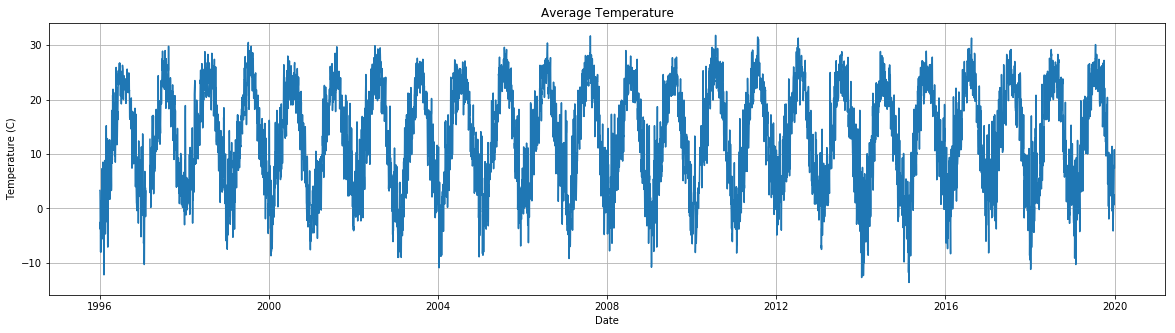

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['avgtTempC'])
ax.set(xlabel='Date', ylabel='Temperature (C)', title='Average Temperature')
ax.grid()
plt.show()

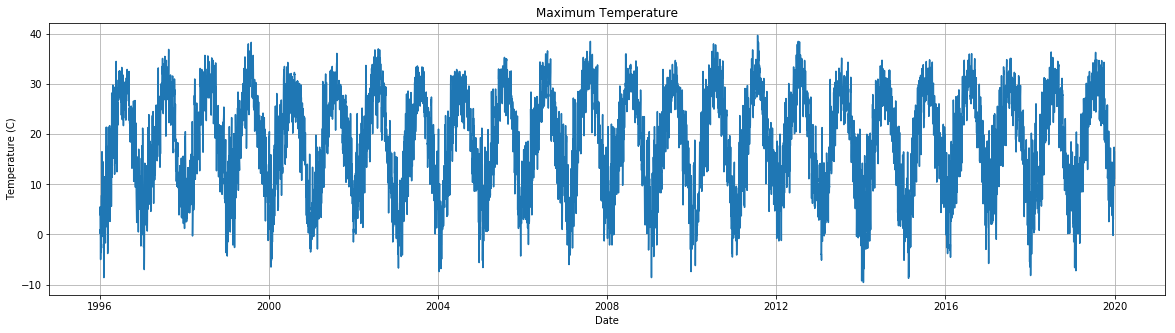

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['maxTempC'])
ax.set(xlabel='Date', ylabel='Temperature (C)', title='Maximum Temperature')
ax.grid()
plt.show()

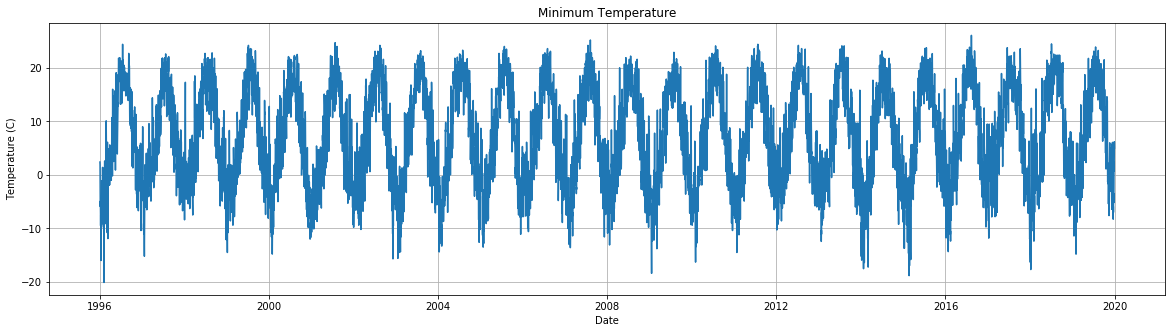

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['minTempC'])
ax.set(xlabel='Date', ylabel='Temperature (C)', title='Minimum Temperature')
ax.grid()
plt.show()

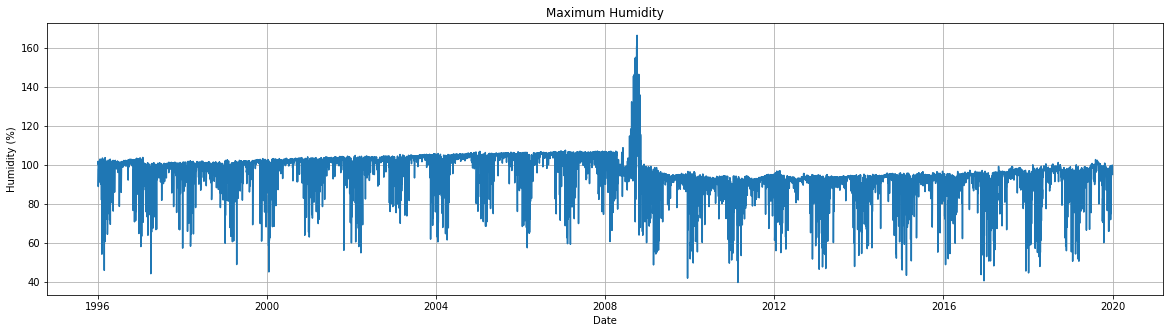

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['maxHumPct'])
ax.set(xlabel='Date', ylabel='Humidity (%)', title='Maximum Humidity')
ax.grid()
plt.show()

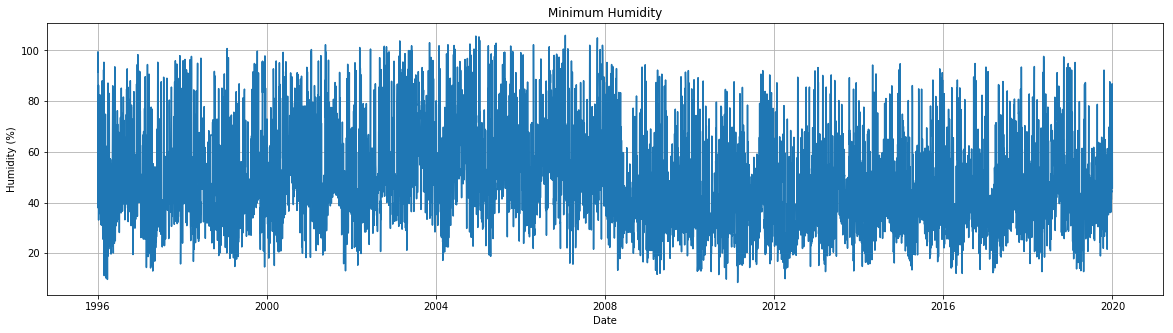

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['minHumPct'])
ax.set(xlabel='Date', ylabel='Humidity (%)', title='Minimum Humidity')
ax.grid()
plt.show()

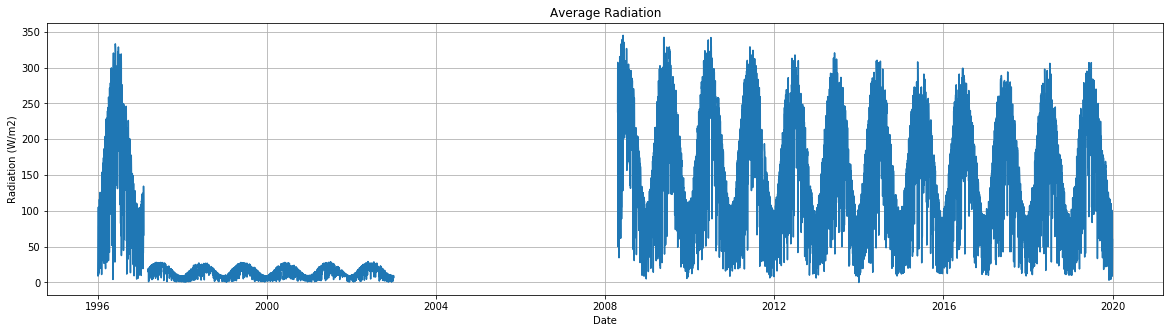

In [53]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['avgRadWm-2'])
ax.set(xlabel='Date', ylabel='Radiation (W/m2)', title='Average Radiation')
ax.grid()
plt.show()

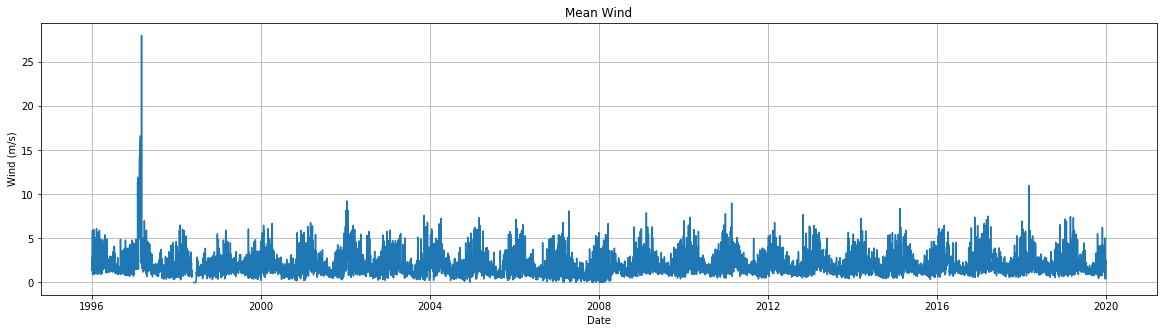

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['meanWindMs-1'])
ax.set(xlabel='Date', ylabel='Wind (m/s)', title='Mean Wind')
ax.grid()
plt.show()

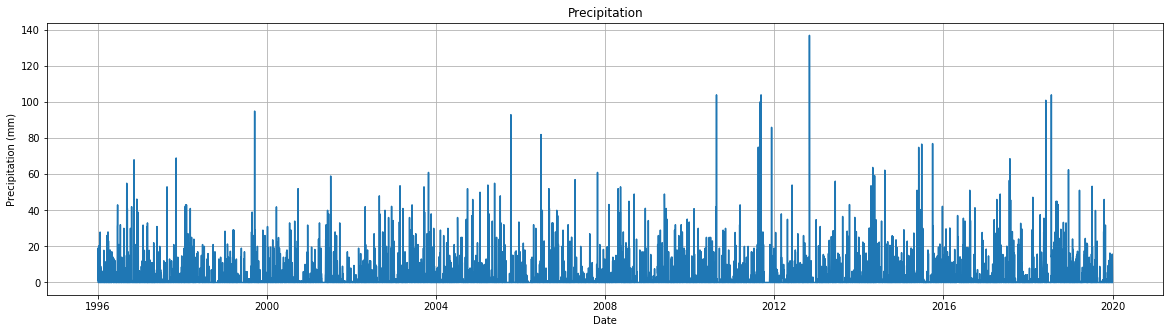

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['PrecipitationMm'])
ax.set(xlabel='Date', ylabel='Precipitation (mm)', title='Precipitation')
ax.grid()
plt.show()

Looking at the graphics, I will not use average radiation because data is missing for years 2003-2008.  I need to check the anomalies for maximum humidity and mean wind and how this can be corrected.

My next step is to work on feature engineering, I will combine crop mangement type in two categories traditional and organic.  After I determine the average number of weeks that takes for each crop to mature I will calculate weather variables weekly average starting from planting date.

I will also calculate growing degree days (GDD) that "are used to estimate the growth and development of plants and insects during the growing season. The basic concept is that development will only occur if the temperature exceeds some minimum development threshold, or base temperature (TBASE). The base temperatures are determined experimentally and are different for each organism". [1]

GDD formula for corn and soybean:

GDD = (Daily Max Temp °C + Daily Min Temp °C) / 2 - 10

GDD formula wheat:

GDD = (Daily Max Temp °C + Daily Min Temp °C) / 2 - 4.4

# References

1. Explanation of Growing Degree Days, Midwestern Regional Climate Center, mrcc.illinois.edu/gismaps/info/gddinfo.htm.
